# Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.optimize import curve_fit  # fit the data with a given form

In [2]:
# import the packages for symbolic regression
import sympy
import pydotplus
from IPython.display import Image
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from sympy.plotting import plot as symplot

In [3]:
# conventional machine learning method
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [4]:
import os
from utils import createDataDic  # Self-mdae function stored in python file

In [5]:
from IPython.display import Image, display, Latex

In [6]:
config = {
    "font.family":'Times New Roman',
    "font.size": 20,
    "mathtext.fontset":'stix',
    "axes.titlesize": 24
}
rcParams.update(config)

# Data Preprocessing

## Getting all Dataset Path 
During this process, we use self-made function to create a dictionary to store paths of our data. The key is the parent folder name, then the child key is the file name without some nonsense postfix, lastly, the child value is the path for specific text file.

In [7]:
current_abs_path = os.path.abspath('.')  # Current absolute path
total_folder_name = 'SK_Data'
data_dic = createDataDic(current_abs_path,
                         total_folder_name)  # Data path dictionary

E:\School 4\BEng Mechanical Engineering Project\AiFeynmanTest\SK_Data\.DS_Store is a file


## Extract Data in Diffuse Model

### Simple Data Composition 
In this section, we use some simple code to give you basic idea of our data composition. The first column is the velocity, the second column is the number of molecules with correesponding velocity, the third column is the probability of correspondng velocity.

In [8]:
tan_velocity_x_path = data_dic['diffusiveWall'][
    'velocity_histogram_tangential_x']
tan_vel_name_x_list = ['vt_x', 'number', 'prob_vtx']
tan_vel_x = pd.read_csv(tan_velocity_x_path, names=tan_vel_name_x_list, 
                        header=None, sep=" ")
tan_vel_x.head(100)

,vt_x,number,prob_vtx
0,-1995,0,0.000000
1,-1985,0,0.000000
2,-1975,0,0.000000
3,-1965,0,0.000000
4,-1955,0,0.000000
...,...,...,...
95,-1045,18,0.000053
96,-1035,13,0.000038
97,-1025,18,0.000053
98,-1015,18,0.000053


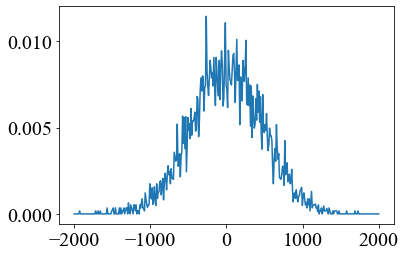

In [9]:
new_prob = [i / tan_vel_x['number'].sum() for i in tan_vel_x['number']]

plt.plot(tan_vel_x['vt_x'], new_prob)

### Visualize the data
1. Key information for constants of methane
- kB: the Boltmann constant, 
- Tw: the temperature of the wall, 
- mi: the molecular mass of methane.
2. In this section, we plot the all probabilities in terms of different velocity components, i.e., normal velocity, tangential velocity and its magnitude. At the same time, we used the most probable speed $v_m$ to scale our velocity, where $v_m = \sqrt{\frac{2 k_B T_w}{mi}}$, so that we could gain non-dimension value here.

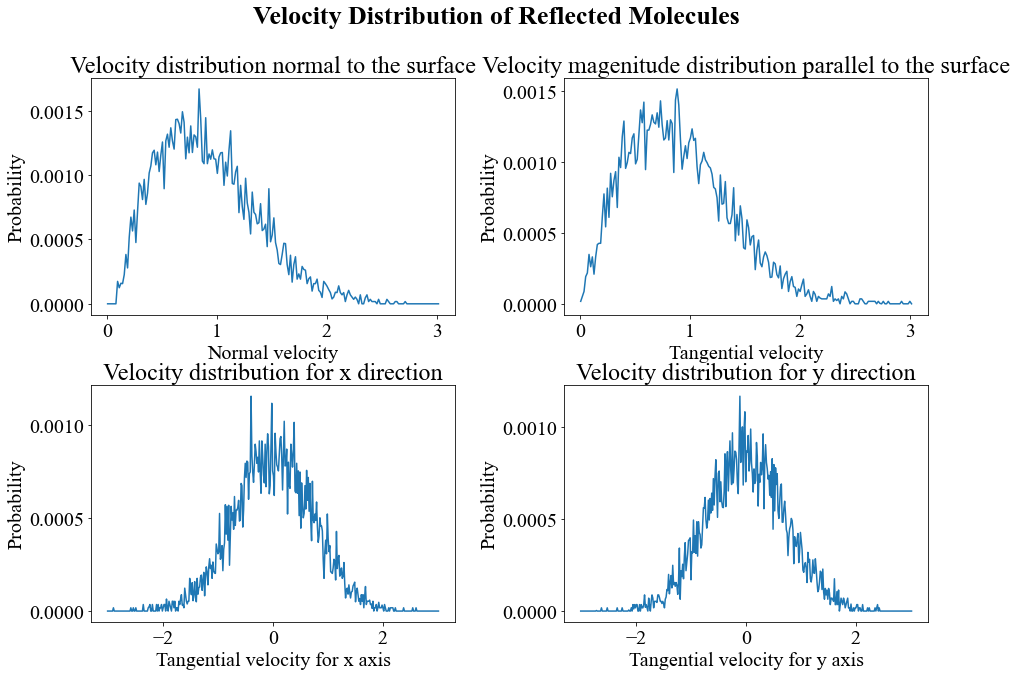

In [10]:
def extracData(folder_name, file_name):
    """
    This is a function to extract the data in corresponding file.
    Variables:
        folder_name: The name of the child folder, e.g., it is diffusiveWall here.
        file_name: The name of the file for the specific velocity
    Returns:
        v: The velocity of this text file.
        number: The number of melocules with the same velocity, v.
        prob: The probability of the velocity, v. 
    Note: All the return values have been converted to numpy ndarray.
    """
    data_path = data_dic[folder_name][file_name]  # The path of the data
    data = pd.read_csv(data_path, header=None, sep=" ")
    data_np = np.array(
        data)  # convert the data from pandas' datafframe to numpy ndarray

    # Extract the data
    v = data_np[:, 0]
    number = data_np[:, 1]
    prob = data_np[:, 2]

    return v, number, prob


def calVm(parameters):
    """
    This is the function to calculate the most probable speed for methane. 
    Variables:
        Parameters: It is a dictionary that contains the properties of gas, the
            key is the name, value is the value of corresponding constant.
            kB: Boltzman const
            Tw: Temperature of the wall
            mi: Molecular mass fof methane
    Returns:
        Vm: The most probable speed.
        Vm0: Some times could be as reference, like Vm.
    """
    kB = parameters['kB']
    Tw = parameters['Tw']
    mi = parameters['mi']

    Vm = np.sqrt(2 * kB * Tw / mi)  # Most probable speed
    Vm0 = np.sqrt(kB * Tw / mi)  # reference velocity factor

    return Vm, Vm0


gas_properties = {
    'kB': 1.38064852e-23,
    'Tw': 423,
    'mi': 2.66389e-26
}  # The corresponding parameter of methane, kB is the Boltmann constant,
# Tw is the temperature of the wall, mi is the molecular mass of methane.
Vm, _ = calVm(gas_properties)

folder_name = 'diffusiveWall'  # Fist child folder name
file_list = [
    'velocity_histogram_normal', 'velocity_histogram_tangential',
    'velocity_histogram_tangential_x', 'velocity_histogram_tangential_y'
]  # The list contains all needed file name
velocity_list = [
    'Normal velocity', 'Tangential velocity', 'Tangential velocity for x axis',
    'Tangential velocity for y axis'
]  # The list contains the different velocity component
title_list = [
    'Velocity distribution normal to the surface',
    'Velocity magenitude distribution parallel to the surface',
    'Velocity distribution for x direction',
    'Velocity distribution for y direction'
]  # The list contains all titles for the graph

font_format = {
    'family': 'Times New Roman',
    'size': 20
}  # Format dictionary for axis
title_format = {
    'family': 'Times New Roman',
    'size': 24
}  # Format dictionary for axis title
suptitle_format = {
    'family': 'Times New Roman'
}  # Format dictionary for superior title

fig = plt.figure(figsize=(15, 10))
fig.suptitle('Velocity Distribution of Reflected Molecules',
             fontdict=suptitle_format,
             fontsize=26,
             fontweight='bold') # Plot the superior title
for i, file in enumerate(file_list):
    v, _, prob = extracData(folder_name, file)
    ax = fig.add_subplot(2, 2, i + 1)
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    ax.plot(v / Vm, prob)
    ax.set_xlabel(velocity_list[i], fontdict=font_format)
    ax.set_ylabel('Probability', fontdict=font_format)
    ax.set_title(title_list[i], fontdict=title_format)

plt.savefig('./figure/diffuse_model_velocity dirstribution.png') # Save the graph

### Fit the Data for Tangential Velocity
1. In this section, we treated empirical normal velocity as our input data, then use curve_fit in scipy package to fit the data to check our data is satisfactory or not. Meanwhile, since we knew the mathematical expression of the corresponding scattering kernel, it is a really good way to compare our fitted data with the theoretical data. Of course, empirical data, fitted data and theoretical data are all plotted in the same graph. Maybe this work could be useless at this time due to the simple scattering kernel, however, it is really helpful for us to get deeper of our data when encountering much more complicated scattering kernels. 

2. During analysis, we would like to use Equation \ref{eq: normal velocity probability} to plot the theoretical value, where $V_{n}$ is the tangential velocity in x direction.
$$f = \frac{m V_n}{k_B T_w}\times\mathrm{exp}\left(-\frac{V_{n}^2}{v_m^2}\right)
\label{eq: normal velocity probability}
$$

3. Form the printing data, we could see that the most probable speed in fitted data is 676. And the theoretical most probable speed is 662, which is really close to the fitted ones even with little differences. As for the value of $\frac{m}{k_B T_w}$, the fitted data and theoretical data is very close to each other, i.e., $4.49\times 10^{-6}$ and $4.56\times 10^{-6}$, respectively, in fact, we could suppose these two values are the same to some extent.

4. From the graph, we could see that the code fitted the data really very well before coming to the maximum, and there are some little difference between fitted data and theoretical ones after the top point. Actually, it does not matter compared to the whole plot.

The size of data is (200,)
Theoretically, the value of B is 4.561343601877912e-06, and the value of A is 662.1686318778972
Fited parameters: B is 4.489586353153203e-06, A is 676.4220413601845


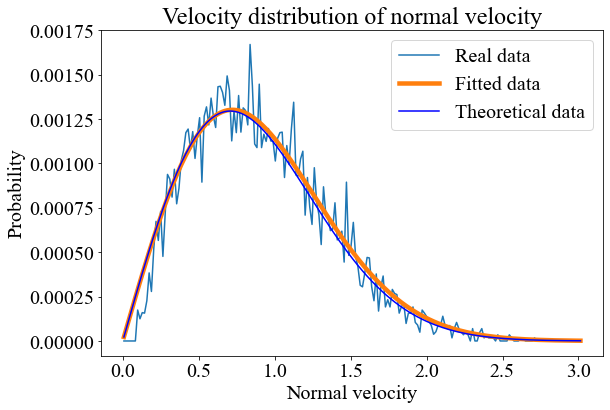

In [11]:
def fitFunctionNormal(x, A, B):
    """
    This is the helpful function inputted in the curve_fit class.
    Variables:
        x: The tangential veloocity 
        A: Fitted paprameter
        B: Fitted paprameter
    Returns:
        y: The value of the fitted function.
    """
    y = (B * x) * np.exp(-(x)**2 / np.square(A))

    return y


def theoDataNormal(x, Cm, parameters):
    """
    This is the function to calculate the theoretical value of corresponding
    scattering kernel.
    Varibales:
        x: The velocity
        Cm: The most probable speed
        kB: Boltzman const
        Tw: Temperature of the wall
        mi: Molecular mass for methane
    Returns:
        f: The theoretical value.
    """
    kB = parameters['kB']
    Tw = parameters['Tw']
    mi = parameters['mi']

    B = mi / (kB * Tw)
    A = 2 * kB * Tw / mi
    x = np.array(x)
    f = B * x * np.exp(-np.square(x) / A)
    print("The size of data is {}".format(f.shape))
    print(
        'Theoretically, the value of B is {}, and the value of A is {}'.format(
            B, np.sqrt(A)))
    
    return f


# Extract the normal velocity data of diffuse scattering kernel
xdata_normal, _, ydata_normal = extracData(folder_name, file_list[0])
f_normal = theoDataNormal(xdata_normal, Vm,
                          gas_properties)  # calculate the theoretical value
guess_normal = [650, 4e-6]
parameters_normal, _ = curve_fit(fitFunctionNormal,
                                 xdata_normal,
                                 ydata_normal,
                                 p0=guess_normal) 
print('Fited parameters: B is {}, A is {}'.format(parameters_normal[1],
                                                  parameters_normal[0]))
fit_y_normal = fitFunctionNormal(xdata_normal, parameters_normal[0],
                                 parameters_normal[1])

# Plot the data
fig = plt.figure(figsize=(9, 6))
plt.plot(xdata_normal / Vm, ydata_normal, label='Real data')
plt.plot(xdata_normal / Vm, fit_y_normal, label='Fitted data', linewidth=4.5)
plt.plot(xdata_normal / Vm, f_normal, label='Theoretical data', linewidth=1.5,
         c='b')
plt.xlabel('Normal velocity', fontdict=font_format)
plt.ylabel('Probability', fontdict=font_format)
plt.title('Velocity distribution of normal velocity', fontdict=title_format)
plt.legend()

plt.savefig('./figure/vn and fitted data.png')

### Prepare the data for Symbolic Regression
In this section, we define a simple function to shuffle the orignal dataset, then split it into two dataset, i.e., training one and test one. 

In [12]:
def splitDataset(X, y, ratio):
    """
    This is the function to split original empirical data, which helps get
    training dataset and test dataset.
    Variables:
        X: one dimention 
        y: one dimension
        ratio: SPlitting ratio
    Return:
        X_train: ndarray
        y_trian: ndarray
        X_test: ndarray
        y_test: ndarray
    """
    # Adding one more axis to make the data 2D
    X = X[:, np.newaxis]
    y = y[:, np.newaxis]
    dataset = np.concatenate((X, y), axis=1)
    print(type(dataset))
    print(dataset.shape)
    np.random.shuffle(dataset)
    index = int(len(X)*ratio)
    print(dataset[0])
    X_train = dataset[:index, :][:, 0]
    y_train = dataset[:index, :][:, 1]
    X_test = dataset[index:, :][:, 0]
    y_test = dataset[index:, :][:, 1]
    
    return X_train, y_train, X_test, y_test


# Spliting dataset
split_ratio = 0.9
X_train, y_train, X_test, y_test = splitDataset(xdata_normal, ydata_normal, split_ratio)

<class 'numpy.ndarray'>
(200, 2)
[7.05000e+02 9.20976e-04]


# Symbolic Regression

## Running Symbolic Regression
In this section, we run the symbolic regression with self-made function, thanksfully, the hyper-parameters this time could give us a good work, but for further work, I am going to establish a class or function which contain all the information together, so that we could train sepcific hyper-paramteter within a range of numer to gain the best regressor object. Of course, the constraint in the job shuld be further invextigated, which has not been done so much until now.

### Symbolic Regression Object
In this subsection, we run the code and print the mathematical symbolic expression, i.e., 
$$ f = 0.003 \times x \times \mathrm{exp}(-x^2)
\label{eq: symbolic normal expression}
$$
, where $x$ is the scaled normal velocity here, which is very close to the theoretical data when using $v_m$ to multiply $x$ here. 

\textbf{Notice}: 
- The constant range has been modified to 0.02, which makes sense here. 
- Parameter list
                                   population_size=1500, 
                                   function_set=fun_set,
                                   generations=300,
                                   stopping_criteria=0.00035,
                                   const_range=(-const_limit, const_limit),
                                   p_crossover=0.7,
                                   p_subtree_mutation=0.1,
                                   p_hoist_mutation=0.05,
                                   p_point_mutation=0.1,
                                   max_samples=0.9,
                                   verbose=1,
                                   parsimony_coefficient=0.01,
                                   random_state=0,
                                   n_jobs=2,
                                   low_memory=True

In [13]:
# self-made function
def _protected_division(x1, x2):
    """Closure of division (x1/x2) for zero denominator."""
    _EPS = 1e-10
    with np.errstate(divide='ignore', invalid='ignore'):
        abs_x2 = np.abs(x2, dtype=np.float64)
        return np.where(
            np.abs(x2) > _EPS, np.divide(x1, x2),
            np.sign(x2) * np.divide(x1, abs_x2 + _EPS))


def _protectedExp(x):
    """
    Clourse of exp for large result.
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        exp_f = np.exp(x**2)
        return np.where(exp_f > 8.9e6, 0, exp_f)

In [16]:
class SelfSyblicRegression():
    """
    Create a class contains=ing all the function we need yo complement
    symbolic regression
    """
    def __init__(self, X, y, const_range, prob_data):
        self.xdata = X
        self.ydata = y
        self.const_range = const_range
        self.font_format = {'family': 'Times New Roman', 'size': 20}
        self.title_format = {'family': 'Times New Roman', 'size': 24}
        self.f_fitted = prob_data['fitted']
        self.f_theo = prob_data['theo']

    def createFunSet(self):
        """
        This is the function to create function set.
        """
        expo_fun = make_function(function=_protectedExp, name='self_exp', arity=1)
        fun_set = ['add', 'sub', 'mul', 'div', 'abs', expo_fun]

        return fun_set
    
    def symRegression(self):
        const_limit = self.const_range
        fun_set = self.createFunSet()

        # Symbolic Regression object
        est_gp = SymbolicRegressor(population_size=1500,
                                   function_set=fun_set,
                                   generations=300,
                                   stopping_criteria=0.00035,
                                   const_range=(-const_limit, const_limit),
                                   p_crossover=0.7,
                                   p_subtree_mutation=0.1,
                                   p_hoist_mutation=0.05,
                                   p_point_mutation=0.1,
                                   max_samples=0.9,
                                   verbose=1,
                                   parsimony_coefficient=0.01,
                                   random_state=0,
                                   n_jobs=2,
                                   low_memory=True)
        
        return est_gp
        
    def printExpressionInfo(self, est_gp):
        """
        This is the function to give final information after symbolic regression,
        and the esymbolic mathematical repression will be printed out.
        """
        converter = {
            'sub': lambda x, y: x - y,
            'div': lambda x, y: x / y,
            'mul': lambda x, y: x * y,
            'add': lambda x, y: x + y,
            'neg': lambda x: -x,
            'abs': lambda x: sympy.Abs(x),
            'pow': lambda x, y: x**y,
            'sin': lambda x: sympy.sin(x),
            'cos': lambda x: sympy.cos(x),
            'inv': lambda x: 1 / x,
            'sqrt': lambda x: x**0.5,
            'self_exp': lambda x: sympy.exp(x**2),
            'square': lambda x: x**2
        }  # Converter set
        
        print(est_gp)
        # print('R2:', est_gp.score(X_test[:, np.newaxis], y_test))  # Give estimation score
        next_e = sympy.sympify(str(est_gp._program), locals=converter)
        print('Expression:', next_e)
        
        return next_e
        
    def plotGraph(self, est_gp):
        """
        This is the function to plot the subtree structured individual
        Variables:
            est_gp: symbolic regressior after fitting
        """
        graph = est_gp._program.export_graphviz()
        graph = pydotplus.graphviz.graph_from_dot_data(graph)
        img = Image(graph.create_png())
        display(img)
        
    def plotProb(self, next_e):
        """
        This is the function to plot the trend of probablity along the normal
        velocity.
        """
        symplot(next_e, xlim=[0, 3], adaptive=False, nb_of_points=400)
        
    def plotComparisonNormal(self, next_e, path):
        """
        Variables:
            next_e: Symbolic expression
            path: File path stored picture
        """
        X0 = sympy.symbols('X0')  # Create the symbols object
        x_scale_list = self.xdata
        est_value = [next_e.subs({X0:value}) for value in x_scale_list] 
        
        # Plot the graph 
        fig = plt.figure(figsize=(9, 6), dpi=600)
        plt.plot(x_scale_list, self.ydata*Vm, label='Traning set', linewidth=2, c='#0e72cc')
#         plt.plot(x_scale_list, self.f_fitted*Vm, label='Fitted data', linewidth=4.5, c='g', alpha=0.8)
        plt.plot(x_scale_list, self.f_theo*Vm, label='Theoretical data', linewidth=1.5, c='#f59311', marker="*", markevery=10)
        plt.plot(x_scale_list, est_value*np.array(Vm), label='Symboic data', linewidth=2, c='#d12a6a')
        plt.xlabel('$\mathrm{Normal\ velocity}\ V_n[-]$', fontdict=self.font_format)
        plt.ylabel('Probability', fontdict=self.font_format)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        
        # Find the maximum difference
        difference_array = self.f_theo*Vm - est_value*np.array(Vm) 
        index = np.argmax(difference_array)
        max_diff = difference_array[index] / (self.f_theo[index]*Vm) * 100 # It should be 100 percent
        plt.title('Velocity distribution of normal velocity \n Maximum difference: {:.2}%'.format(max_diff),
                  fontdict=self.title_format)
        plt.legend(fontsize=20)
        plt.savefig(path)
        
        plt.show()


    def run(self):
        """
        This is the main function that help us run the whole symbolic regression.
        """
        # 1. Create estimation object of gplearn
        est_gp = self.symRegression()
        
        # Change the data dimension, so that we could feed it into symbolic regression ovject.
        X_train_1 = self.xdata[:, np.newaxis]
        y_train_1 = self.ydata

        # 2. Fit the data
        est_gp.fit(X_train_1, y_train_1)

        # 3. Print expression
        print('-'*50, 'INFO', '-'*50)
        next_e = self.printExpressionInfo(est_gp) # symbolic expression
        
        # 4. Plot Graph
        print('-'*50, 'SUBTREE', '-'*50)
        self.plotGraph(est_gp)

        # 5. Plot probability 
        print('-'*50, 'PROBABILITY', '-'*50)
        self.plotProb(next_e)
        
        return next_e
        

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.38      3.09169e+10        5      0.000433135      0.000479771     31.45m
   1     8.26          2805.91        5      0.000423207      0.000631669     10.48m
   2     2.77          415.547        3      0.000425001      0.000543355      7.70m
   3     1.48       3.7705e+08        2      0.000438295      0.000412175     10.14m
   4     1.47          2274.71        1      0.000422419      0.000770239     10.11m
   5     1.40          82025.9        1      0.000418686      0.000803829     10.05m
   6     1.48          269.996        1      0.000421492      0.000778575     11.29m
   7     1.43          142.563        1      0.000419555      0.000796006      9.22m
   8     1.44          245.142        1       0.00041822       0.00080803  

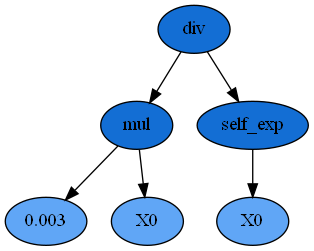

-------------------------------------------------- PROBABILITY --------------------------------------------------


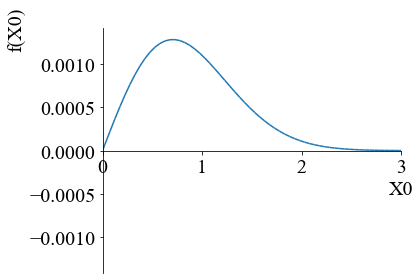

In [17]:
xdata_normal_1 = xdata_normal / Vm # Normaliza the data
prob_data = {'fitted':fit_y_normal, 'theo':f_normal}
symbolic_object = SelfSyblicRegression(xdata_normal_1, ydata_normal, const_range=2e-2, prob_data=prob_data)
next_e = symbolic_object.run()

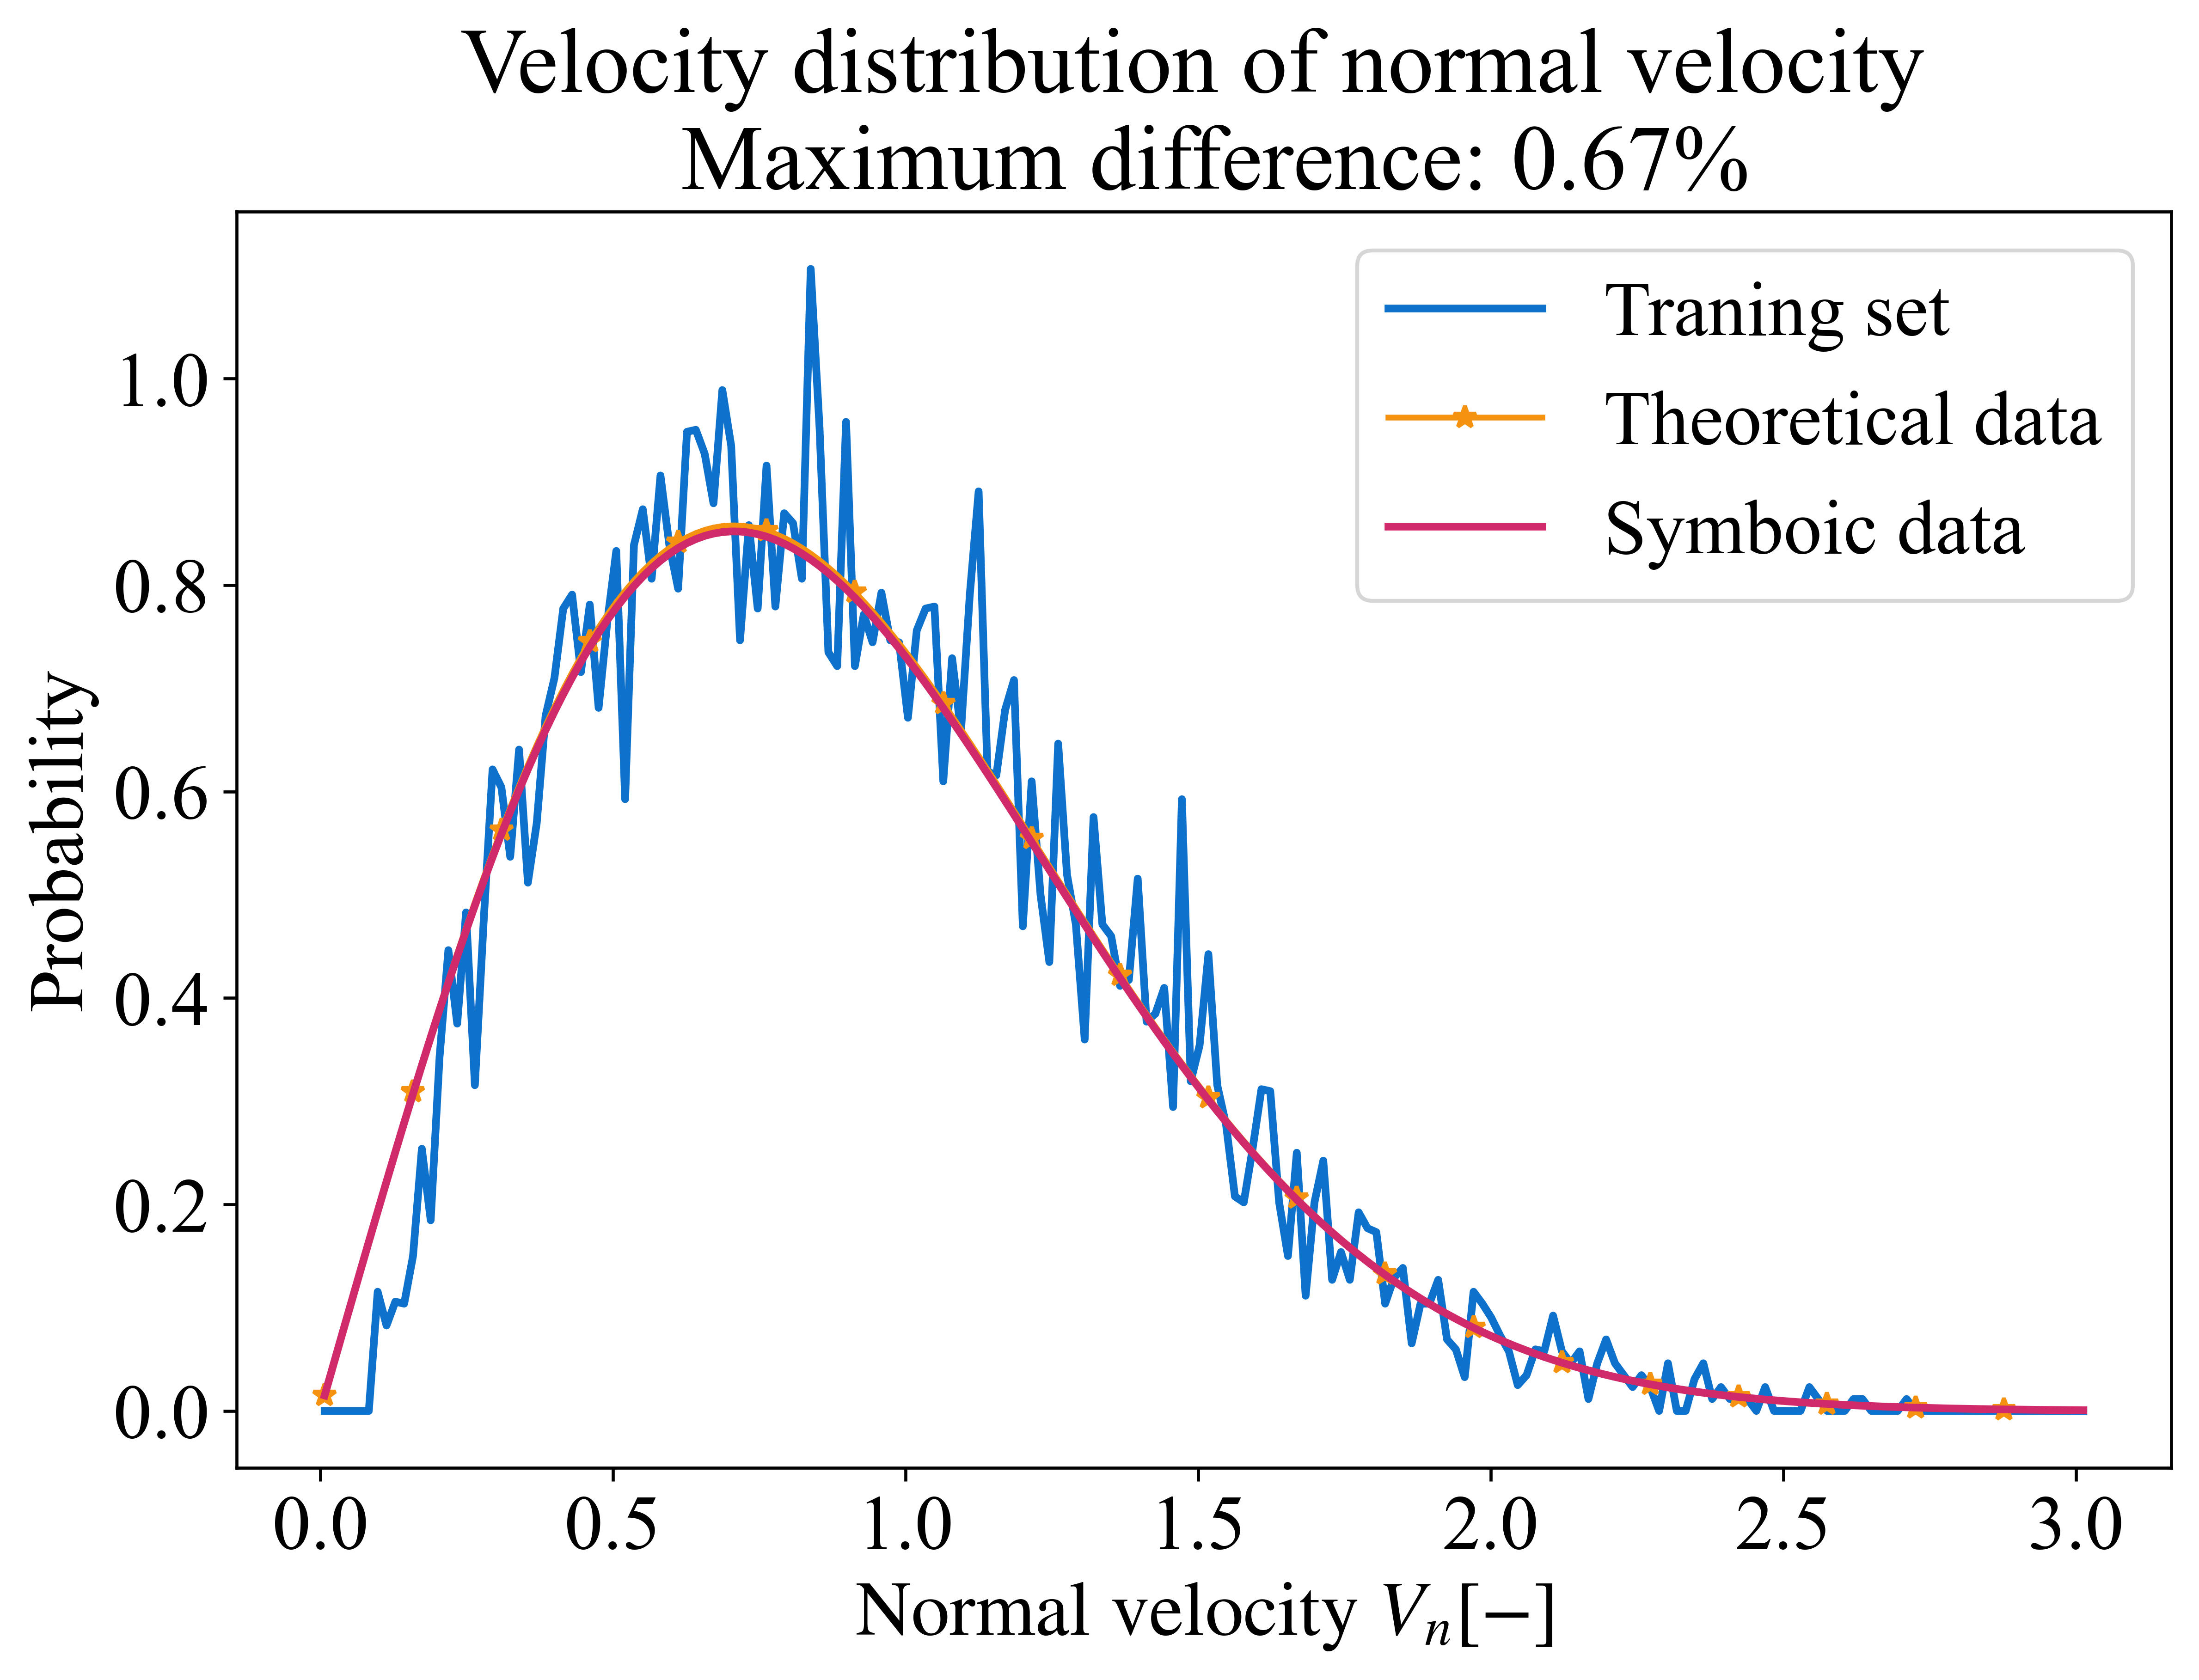

In [16]:
normal_path = './gp_diffuse_kernel_normal.png'
symbolic_object.plotComparisonNormal(next_e, path=normal_path)

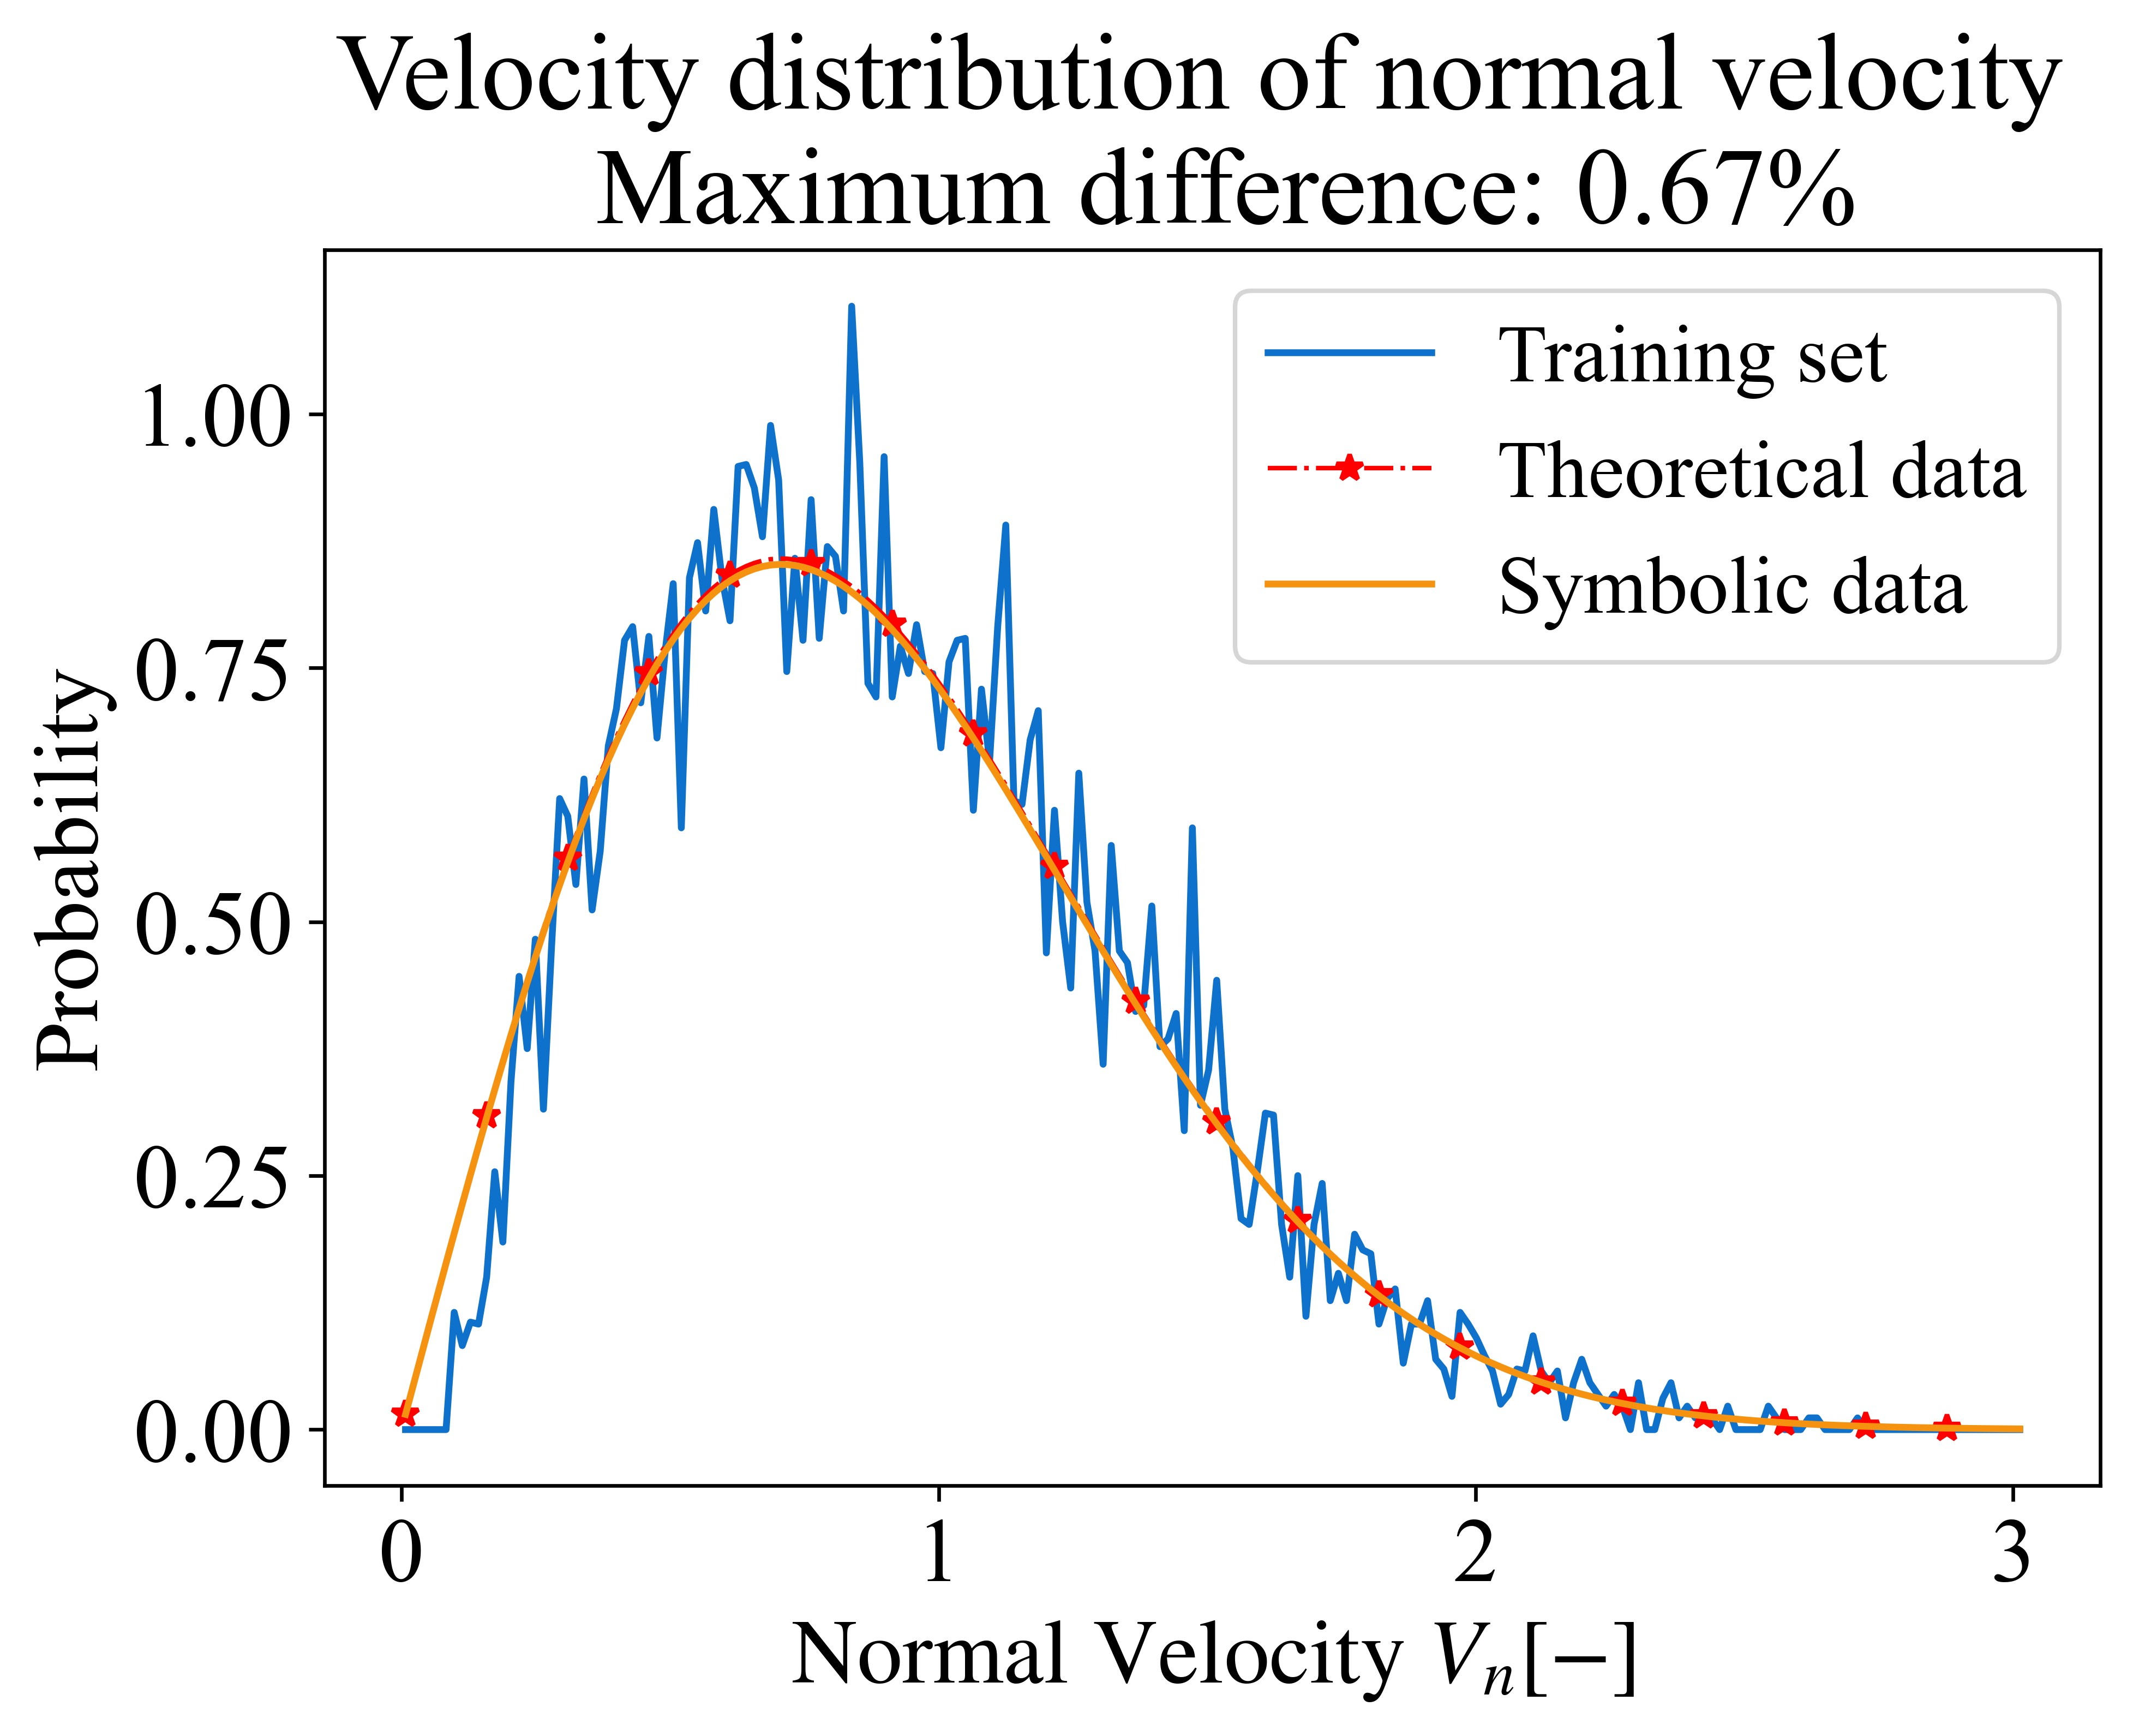

In [19]:
key="Normal"
def func(X):
    return 0.003*X*np.exp(-X**2)


# func = gp.compile(best_tree_normal, pset=pset)
y_sym = func(xdata_normal_1)
# y_sym = symbolicData(X_NORMAL[:, 0], X_NORMAL[:, 1])
# y_Yam = Yamamoto(X_TRAIN[:, 0], X_TRAIN[:, 1])
fig = plt.figure(figsize=(7, 5), dpi=600)
plt.plot(xdata_normal_1, ydata_normal*Vm, label="Training set", c='#0e72cc')
plt.plot(xdata_normal_1, f_normal*Vm, 'r-.', label='Theoretical data', linewidth=1, marker="*", markevery=10)
# plt.plot(X_TRAIN[:, 0], y_Yam, 'r-.', label="Yamamoto kernel", linewidth=1, marker="*", markevery=10)
plt.plot(xdata_normal_1, y_sym*Vm, label="Symbolic data", linewidth=1.5, c='#f59311')
if key == "Tangential":
    plt.xlabel("$\mathrm{Tangential\ Velocity}\ V_t [-]$")
elif key == "Normal":
    plt.xlabel("$\mathrm{Normal\ Velocity}\ V_n [-]$")

plt.ylabel("Probability")
# plt.title("Velocity Distribution")
difference_array = f_normal*Vm - y_sym*np.array(Vm) 
index = np.argmax(difference_array)
max_diff = difference_array[index] / (f_normal[index]*Vm) * 100 # It should be 100 percent
plt.title('Velocity distribution of normal velocity \n Maximum difference: {:.2}%'.format(max_diff))
plt.legend(fontsize=18)
plt.savefig("./gp_diffuse_kernel_normal.svg", format='svg', dpi=1600, bbox_inches="tight")

plt.show()

In [17]:
x = sympy.symbols('X0')
sympy.init_printing(use_unicode=True)

next_e_new = next_e.subs(x, x/Vm)
# Set the integration limit
# lower_limit = sympy.N(xdata_normal.min()/Vm, 4)
# upper_limit = sympy.N(xdata_normal.max()/Vm, 4)
lower_limit = 0
upper_limit = sympy.oo
int1 = sympy.Integral(next_e_new, (x, lower_limit, upper_limit))
display(Latex(f"$${sympy.latex(int1)} = {sympy.latex(int1.doit())} = {sympy.latex(int1.doit().evalf(6))}$$"))

<IPython.core.display.Latex object>

## Comparison between Symbolic Regression and Empirical Data
In this section, we plot four kinds of data in one graph, i.e., empirical data, symbolic regression data, fitted data, and theoretical data. From the graph, it is clearly noticed that the symbolic line is extremely closed to the theoretical line, both of which could reflect the empirical data well. 

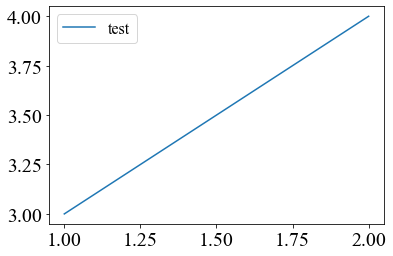

In [18]:
plt.plot(np.array([1, 2]), np.array([3, 4]), label='test')
plt.legend(fontsize=16)

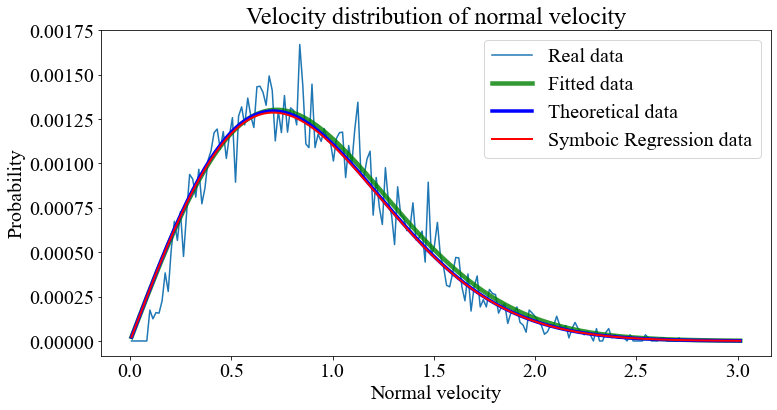

In [19]:
X0 = sympy.symbols('X0')  # Create the symbols object
x_scale_list = xdata_normal/Vm
est_value = [next_e.subs({X0:value}) for value in x_scale_list] 

# Plot the graph 
fig = plt.figure(figsize=(12, 6))
plt.plot(xdata_normal / Vm, ydata_normal, label='Real data')
plt.plot(xdata_normal / Vm, fit_y_normal, label='Fitted data', linewidth=4.5, c='g', alpha=0.8)
plt.plot(xdata_normal / Vm, f_normal, label='Theoretical data', linewidth=3.5, c='b')
plt.plot(x_scale_list, est_value, label='Symboic Regression data', linewidth=2, c='r')
plt.xlabel('Normal velocity', fontdict=font_format)
plt.ylabel('Probability', fontdict=font_format)
plt.title('Velocity distribution of normal velocity',
          fontdict=title_format)
plt.legend()

plt.savefig('./figure/diffuse_model_vn and symbolic regression data_2.png')

## Comparison to Conventional Machine Learning
Even we could gain a really good result on training dataset, we did a little terrible in our testing set compared to the decession tree and random forest tree methods. For this part, I am not going to spend much time on it due to the non-importance for our project.

In [20]:
# Create conventional regression object
est_tree = DecisionTreeRegressor()
est_tree.fit(X_train_1, y_train_1)
est_rf = RandomForestRegressor(n_estimators=10)
est_rf.fit(X_train_1, y_train_1)

b = np.argsort(X_test)
X_test_new = np.array([X_test[i] for i in b])
y_test_new = np.array([y_test[i] for i in b])

X_test_1 = X_test_new[:, np.newaxis]  # Change the dimension

# Predict the data and gain the score
y_gp = est_gp.predict(X_test_1)
score_gp = est_gp.score(X_test_1, y_test)
y_tree = est_tree.predict(X_test_1)
score_tree = est_tree.score(X_test_1, y_test)
y_rf = est_rf.predict(X_test_1) 
score_rf = est_rf.score(X_test_1, y_test)

NameError: name 'X_train_1' is not defined

In [ ]:
fig = plt.figure(figsize=(16, 6))
font_format_title = {'family': 'Times New Roman', 'size': 20}
font_format = {'family': 'Times New Roman', 'size': 16}

info_list = [(y_gp, score_gp, "Symbolic Regressor"),
             (y_tree, score_tree, "Decession Tree"),
             (y_rf, score_rf, 'Random Forest')]

for i, (y, score, title) in enumerate(info_list):
    ax = fig.add_subplot(1, 3, i + 1)
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    ax.set_xlabel('Velocity', fontdict=font_format)
    ax.set_ylabel('Probability', fontdict=font_format)
    ax.plot(X_test_new/Vm, y, label='Code')
    ax.plot(X_test_new/Vm, y_test_new, label='Orignal')
    ax.text(-3, 0.0009, r"$R^2=\/ %.6f$" % score, fontsize=14)
    plt.title(title, fontdict=font_format_title)
    plt.legend()
plt.show()